In [1]:

import os   # handling the files
import pickle # storing numpy features
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

In [2]:
image_path = '/kaggle/input/flickr30k/flickr30k_images'
caption_path = '/kaggle/input/flickr30k/captions.txt'
my_path = '/kaggle/working'

In [3]:
#use this to load features then skip below 4 cells 
features_path = '/kaggle/input/features/features32.pkl'
with open(features_path, 'rb') as file:
    features = pickle.load(file)

In [ ]:
# initialise pretrained model
model = InceptionV3(weights='imagenet')
model = Model(model.input, model.layers[-2].output)

# Summerize
# print(model.summary())

In [ ]:
#process the image before feeding to model
def preprocess(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
# extract features from image
features = {}

for img_name in os.listdir(image_path):
    # load the image from file
    img_path = image_path + '/' + img_name
    image = preprocess(img_path)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(my_path, 'features.pkl'), 'wb'))

In [4]:
doc = open(caption_path,'r').read()[33:]
print(doc[:500])


1000092795.jpg,0,Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg,1,Two young  White males are outside near many bushes .
1000092795.jpg,2,Two men in green shirts are standing in a yard .
1000092795.jpg,3,A man in a blue shirt standing in a garden .
1000092795.jpg,4,Two friends enjoy time spent together .
10002456.jpg,0,Several men in hard hats are operating a giant pulley system .
10002456.jpg,1,Workers look down from up above on a piece of equ


In [5]:
# Make a dictionary having key(image id) and value(list of caption related to that image)
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split(',')
        if len(line) > 2:
            image_id = tokens[0].split('.')[0]
            image_desc = ' '.join(tokens[2:])
            if image_id not in descriptions:
                descriptions[image_id] = list()
            descriptions[image_id].append(image_desc)

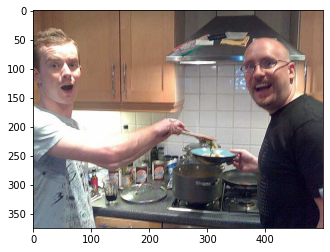

['Two men  one in a gray shirt  one in a black shirt  standing near a stove .',
 'Two guy cooking and joking around with the camera .',
 'Two men in a kitchen cooking food on a stove .',
 'Two men are at the stove preparing food .',
 'Two men are cooking a meal .']

In [6]:
import matplotlib.pyplot as plt
# demo of work done by above method
pic = '1000366164.jpg'
x=plt.imread(image_path+'/'+pic)
plt.imshow(x)
plt.show()
descriptions['1000366164']

In [7]:
#clean captions
def clean(mapping):
    for id, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [8]:
clean(descriptions)

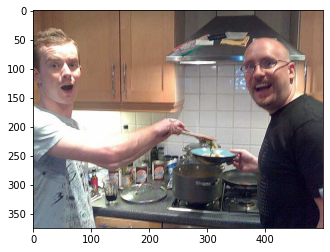

['startseq two men one in gray shirt one in black shirt standing near stove endseq',
 'startseq two guy cooking and joking around with the camera endseq',
 'startseq two men in kitchen cooking food on stove endseq',
 'startseq two men are at the stove preparing food endseq',
 'startseq two men are cooking meal endseq']

In [9]:
# demo of work done by above method
pic = '1000366164.jpg'
x=plt.imread(image_path+'/'+pic)
plt.imshow(x)
plt.show()
descriptions['1000366164']

In [10]:
np.save('description32k.npy', descriptions)

In [11]:
# We create a vocabulary of all the unique words present across all the image captions in the dataset.

vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 20285


In [12]:
#Create a list of all the training captions
all_captions = []
for key, val in descriptions.items():
    for cap in val:
        all_captions.append(cap)

In [13]:
#reduce our vocabulary to only those words which repeat at least 10 times in the entire corpus, to make
#model more robust
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 5446


In [14]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

18319


In [15]:
index_to_word = {v:k for k,v in tokenizer.word_index.items()}


In [16]:
np.save('vocabMapping32k.npy', index_to_word)

In [17]:
def idx_to_word(integer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [18]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

In [19]:
# spliting image ids for training and testing model
image_ids = list(descriptions.keys())
split = int(len(image_ids) * 0.85)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, vocab_size, batch_size):
    # loop over images
    X1 = []
    X2 = []
    y = []
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1 = []
                X2 = []
                y = []
                n = 0

In [ ]:
#without attention

from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Attention, Concatenate
from tensorflow.keras.models import Model

# Image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256,return_sequences=True)(se2)

attn = Attention()([fe2, se3])
merged = add([fe2, attn])
decoder1 = LSTM(256)(merged)
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Decoder model
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Complete model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

In [21]:
#with attention

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Attention, Concatenate
from tensorflow.keras.models import Model

# Image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Complete model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 74)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 74, 256)      4689664     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [22]:
#freeze trainable parameter of model
model.layers[2].trainable = False

In [23]:
#compile the model using Categorical_Crossentropy as the Loss function and Adam as the optimizer.
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [24]:
# train the model
epochs = 10
batch_size = 12

steps = len(train) // batch_size

# for i in range(epochs):
    # create data generator
generator = data_generator(train, descriptions, features, vocab_size, batch_size)
    # fit for one epoch
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

    

Epoch 1/10
2251/2251 [==============================] - 421s 185ms/step - loss: 5.4748
Epoch 2/10
2251/2251 [==============================] - 416s 185ms/step - loss: 4.2654
Epoch 3/10
2251/2251 [==============================] - 416s 185ms/step - loss: 3.9438
Epoch 4/10
2251/2251 [==============================] - 413s 184ms/step - loss: 3.7441
Epoch 5/10
2251/2251 [==============================] - 414s 184ms/step - loss: 3.6005
Epoch 6/10
2251/2251 [==============================] - 412s 183ms/step - loss: 3.4901
Epoch 7/10
2251/2251 [==============================] - 413s 183ms/step - loss: 3.4070
Epoch 8/10
2251/2251 [==============================] - 412s 183ms/step - loss: 3.3405
Epoch 9/10
2251/2251 [==============================] - 412s 183ms/step - loss: 3.2874
Epoch 10/10
2251/2251 [==============================] - 412s 183ms/step - loss: 3.2433


In [ ]:
# from keras.models import load_model
# model = load_model('/kaggle/input/model32/model32.h5')

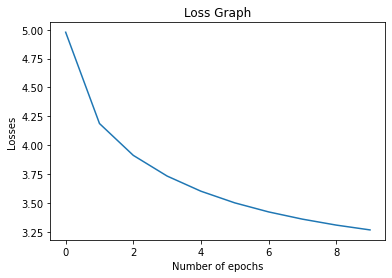

In [25]:
#Plot loss graph
loss_values = history.history['loss']
epochs = list(range(len(loss_values)))
plt.plot(epochs, loss_values)
plt.title("Loss Graph")
plt.xlabel("Number of epochs")
plt.ylabel("Losses")
plt.show()

In [26]:
# save the model
model.save(my_path+'/attentionModel32K.h5')

In [27]:
# done with training, that will give a long vector with a probability distribution across all the words in the vocabulary.

def testing(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat)
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [28]:
pip install rouge-score

  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24956 sha256=7da7ea9e5df2bf8abab5850a19998161b9146a669bd2dfe0dc17c5d3ff9491e1
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [29]:
from rouge_score import rouge_scorer

In [30]:
def get_list_of_caption(id):
    res = ''
    for val in descriptions[id]:
        res += val.lower()
        res += ','
    return res

In [31]:
def get_weight_list(n):
    weights = [1.0 / n] * n 
    return weights

In [36]:
#validating captions
from nltk.translate.bleu_score import sentence_bleu
# validate with test data
actual, predicted = list(), list()
#  with open ("mapped.txt" , "w+") as f:

for key in test:
    # get actual caption
    captions = descriptions[key]
    # predict the caption for image
    y_pred = testing(features[key])

     #writing key,caption and predicted caption
    #     f.write(key + "\t" + captions + "\t" + y_pred)
    #     f.write('\n')

    ref_cap = get_list_of_caption(key)
    gen_cap = y_pred.lower()

    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred_token = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
blue_score1 = sentence_bleu(actual_captions, y_pred_token,weights=get_weight_list(1))
blue_score2 = sentence_bleu(actual_captions, y_pred_token,weights=get_weight_list(2))
blue_score3 = sentence_bleu(actual_captions, y_pred_token,weights=get_weight_list(3))
blue_score4 = sentence_bleu(actual_captions, y_pred_token)

scorer = rouge_scorer.RougeScorer(['rouge1'])
roug_scores = scorer.score(ref_cap, gen_cap)
for key in roug_scores:
    print(f'{key}: {roug_scores[key]}')


rouge1: Score(precision=0.8333333333333334, recall=0.10526315789473684, fmeasure=0.18691588785046728)


In [37]:
print("Blue score of 1gram : ", blue_score1)
print("Blue score of 2gram : ", blue_score2)
print("Blue score of 3gram : ", blue_score3)
print("Blue score of 4gram : ", blue_score4)
for key in roug_scores:
    print(f'{key}: {roug_scores[key]}')

Blue score of 1gram :  0.6490006525595041
Blue score of 2gram :  0.30314779366662803
Blue score of 3gram :  0.4151882627883866
Blue score of 4gram :  0.4858927238536697
rouge1: Score(precision=0.8333333333333334, recall=0.10526315789473684, fmeasure=0.18691588785046728)


In [32]:
def func(id):
    res = []
    for i in descriptions[id]:
        res.append(i.lower().split())
    return res

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(image_path, image_name)
    image = Image.open(img_path)
    captions = descriptions[image_id]
    
    print("-------Actual Captions---------")
    for caption in captions:
        print(caption)
    # predict the caption
    print("-------predicted Captions---------")
    y_pred = testing(features[image_id])
    
    reference_captions = get_list_of_caption(image_id)


    # Tokenize captions
    tokenized_gen_captions = y_pred.split()

    # tokenized_ref_captions = reference_captions.split()
    tokenized_ref_captions = func(image_id)

    # Calculate BLEU scores
    bleu_scores1 = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions,weights=get_weight_list(1))
    bleu_scores2 = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions,weights=get_weight_list(2))
    bleu_scores3 = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions,weights=get_weight_list(3))
    bleu_scores = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions)

    print("Predicted Caption:",y_pred)
    print(f"BLEU Score1: {bleu_scores1}")
    print(f"BLEU Score2: {bleu_scores2}")
    print(f"BLEU Score3: {bleu_scores3}")
    print(f"BLEU Score4: {bleu_scores}")



    plt.imshow(image)

-------Actual Captions---------
startseq women are seated at picnic table eating while man in white t-shirt and yellow and orange balloon design on his head stands in the background endseq
startseq an elderly woman is eating burger while the man next to her touching his hat endseq
startseq man with balloon hat and people eating outdoors at picnic tables endseq
startseq two older women sit at table with two coolers in front of them endseq
startseq gray-haired person with glasses enjoys sandwich endseq
-------predicted Captions---------
Predicted Caption: two men are sitting on bench in front of an orange truck
BLEU Score1: 0.6133629430862155
BLEU Score2: 0.32031835014760945
BLEU Score3: 0.21134443188622049
BLEU Score4: 0.30527785817943415


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


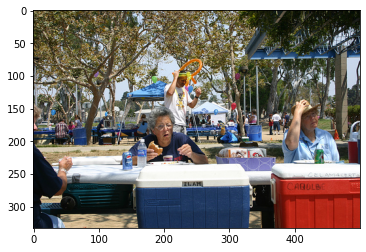

In [39]:
generate_caption("1013536888.jpg")